In [238]:
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib notebook

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# Часть 1

1. Пусть G - событие, сосотоящее в том, что подсудимый виновен, а В - событие, сосотоящее в том, что группа крови принадлежит редкой группе.
Прокурор оценил вероятность $p(B|\overline{G}) = 0.01$, откуда не следует, что $p(G|B) = 0.99$. Отсюда можно лишь сделать вывод, что $p(\overline{B}|\overline{G}) = 0.99$.

2. Для определения вероятности виновности необходимо оценить:

$$p(G|B) = \frac{p(B|G)p(G)}{p(B)} = \frac{p(B|G)p(G)}{p(B|G)p(G) + p(B|\overline{G})p(\overline{G})} $$
Мы знаем, что найденная кровь принадлежит убийце, соответственно $p(B|G) = 1$. Также прокурор уже оценил $p(B|\overline{G}) = 0.01$. Остаётся оценить априорные вероятности $p(G)$ и $p(\overline{G})$. Вместо этого адвокат оценил априорную вероятность $p(G|B)$.

3. Обозначим за x вероятность false negatives, а за y - вероятность false positives.
$$p1 = p(d=1|t=1) = \frac{p(t=1|d=1)p(d=1)}{p(t=1|d=1)p(d=1) + p(t=1|d=0)p(d=0)} = \frac{(1 - x)p(d=1)}{(1 - x)p(d=1) + yp(d=0)} = \frac{0.01(1 - x)}{0.01(1 - x) + 0.99y}$$
$$p2 = p(d=1|t=0) = \frac{p(t=0|d=1)p(d=1)}{p(t=0|d=1)p(d=1) + p(t=0|d=0)p(d=0)} = \frac{0.01x}{0.01x + 0.99(1-y)}$$
Построим графики:

<IPython.core.display.Javascript object>


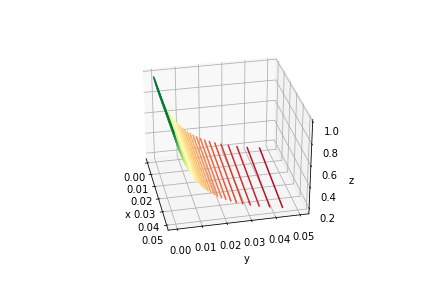

In [8]:
def get_p1(x, y):
    return 0.01*(1 - x) / (0.01 * (1 - x) + 0.99 * y)

def get_p2(x, y):
    return 0.01 * x / (0.01 * x + 0.99 * (1 - y))

x = np.linspace(0, 0.05, 500)
y = np.linspace(0, 0.05, 500)
X, Y = np.meshgrid(x, y)
p1 = get_p1(X, Y)
p2 = get_p2(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p1, 50, cmap='RdYlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

<IPython.core.display.Javascript object>


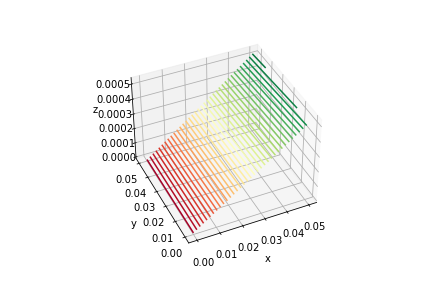

In [9]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, p2, 50, cmap='RdYlGn')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

Для медицинского теста гораздо важнее снизить вероятность $p(d=1|t=0)$, чем повысить вероятность $p(d=1|t=1)$, а $p(d=1|t=0)$ растёт быстрее по x, чем по y. Таким образом, более правильным решением будет уменьшать число false negatives.

# Часть 2

## Задание 1

Готовим данные

In [452]:
data = pd.read_csv('owid-covid-data.csv')

In [453]:
data_russia = data[data['location'] == 'Russia']

In [454]:
start_date = datetime.strptime('2020-03-02', '%Y-%m-%d')

In [455]:
start_date

datetime.datetime(2020, 3, 2, 0, 0)

In [456]:
data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)

<ipython-input-456-0f16b0453dc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)


In [457]:
data_russia = data_russia[data_russia['days'] > 0]

In [458]:
data_russia['new_cases'] = data_russia['new_cases'].transform(lambda x: 1 if x == 0 else x)

In [459]:
train_data_russia = data_russia[data_russia['days'] <= 50]
test_data_russia = data_russia[data_russia['days'] > 50]

## Задание 2

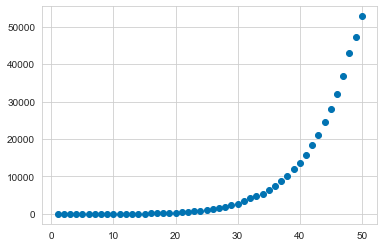

In [460]:
%matplotlib inline
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

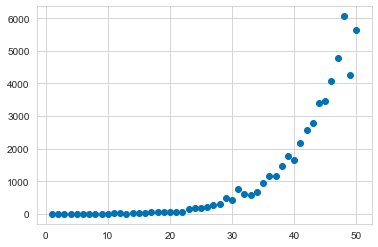

In [461]:
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy())
plt.show()

### 2.a

Для обучения модели в предположении экспоненциальности роста числа заболевших прологарифмируем целевую переменную

In [462]:
train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))

<ipython-input-462-72c8d764991b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))


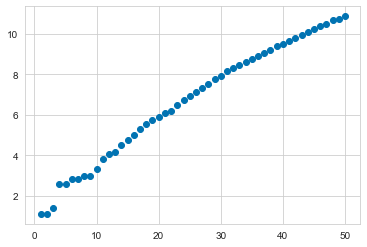

In [463]:
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

Как мы видим после логарифмирования зависимости целевых переменных от дней стали квазилинейными. Таким образом, можно попытаться обучить линейную модель.

In [464]:
exp_model = LinearRegression()
exp_model.fit(train_data_russia['days'].to_numpy().reshape(-1, 1), train_data_russia['total_cases'])

LinearRegression()

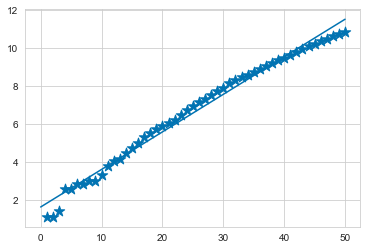

In [465]:
def predicted_curve(x):
    return x * exp_model.coef_ + exp_model.intercept_

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([0] + list(train_data_russia['days'].to_numpy()), predicted_curve([0] + list(train_data_russia['days'].to_numpy())))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 2.b

Оценим дисперсию шума в данных исходя из параметров полученной модели:

In [466]:
def get_disp(X, Y, w0, w1):
    return np.sum((Y - w0 - X * w1)**2) / len(X)

In [467]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), exp_model.intercept_, exp_model.coef_)

In [468]:
sigma = math.sqrt(disp)

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [469]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [470]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [471]:
def plot_w_space_heatmap(X, Y, sigma, w0_lim=[-1, 1], w1_lim=[-1, 1]):
    w0 = np.linspace(w0_lim[0], w0_lim[1], 1000)
    w1 = np.linspace(w1_lim[0], w1_lim[1], 1000)
    w0, w1 = np.meshgrid(w0, w1)
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1
    plt.xlim((w0_lim[0], w0_lim[1]))
    plt.ylim((w1_lim[0], w1_lim[1]))
    p = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    plt.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


In [472]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma)

<ipython-input-471-0d8cdc2cc10b>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


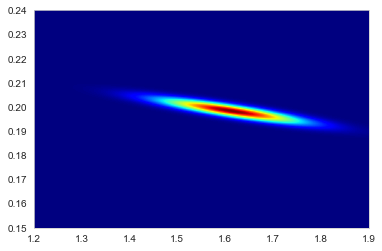

In [473]:
plot_w_space_heatmap(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma, [1.2, 1.9], [0.15, 0.24])

### 2.c

In [474]:
def plot_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60), math.exp(w[0] + w[1]*91), math.exp(w[0] + w[1]*183))
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)

In [475]:
def plot_new_cases_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs) - np.exp(w[0] + w[1]*(xs - 1)), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60) - math.exp(w[0] + w[1]*59),
              math.exp(w[0] + w[1]*91) - math.exp(w[0] + w[1]*90),
              math.exp(w[0] + w[1]*183) - math.exp(w[0] + w[1]*182))
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)

733909.124667087 331898618.30464214 2.5202175981558684e+16
655080.5110669235 284001417.67973876 1.902534956246524e+16
731178.254124592 319935175.98077536 2.2028421165165476e+16
890925.4017101518 499361407.8069587 7.169225032373936e+16
755593.9424462315 336022310.18011177 2.427644705510496e+16
745483.0895600666 359194626.2895127 3.2920091195205468e+16
1003177.0071833099 587379678.4294066 9.599915992315739e+16
925731.545462979 501961779.0704424 6.531724750438749e+16
732060.0741782256 344957330.15870225 2.9592965457025804e+16
657462.2874174403 281055975.38772875 1.805885879307096e+16
740770.3046998034 343891438.94824255 2.8223506137160584e+16
838304.2922040559 438843741.3240496 5.144318504989459e+16
693586.0921713592 313710918.7060705 2.3831885398301524e+16
721409.3682095961 356788660.1579414 3.533362667549141e+16
664139.4584013462 301622393.8521029 2.319317532920975e+16
765205.6269570169 361506055.93538165 3.1250638415619244e+16
745935.9476193215 372568241.62963563 3.7990078608925464e+16

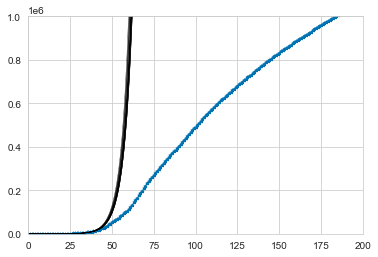

In [477]:
plot_sample_exponents(sigma, 20, xlim=(0, 200), ylim=(0, 1000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

Полученная модель предсказывает более 600000 случаев заражения к 1 мая, более 200000000 к 1 июня и более 10^16 к 1 сентября, что, как мы видим, на деле оказалось не так. С новыми случаями заражения ситуация идентичная:

123403.93438375439 51767594.370541096 3145145608362138.0
175485.23820559448 100189419.45494497 1.5193005508892824e+16
155981.77215111395 79439864.99795878 8582444407993168.0
127642.45349837479 63009712.0473004 6205264239584684.0
125006.44359039178 56142010.827629656 4176329907879380.0
167070.55840408057 91369432.68902653 1.2195077197834288e+16
120776.10839417926 51448384.379494786 3271333450765582.0
119468.93735942943 55365185.80142912 4520460022562444.0
148750.53367675142 73266586.80876422 7167952184255636.0
140312.58676068694 69224086.2364726 6805544606026416.0
119159.6631667018 49687663.01398009 2965421998861332.0
135914.20833913237 61036127.83341515 4539359079762172.0
120381.35752787918 49374647.20552853 2805755168055540.0
132922.0215132382 60405419.783981204 4653585381285068.0
142340.99213317572 70900645.04173326 7171342267728692.0
164004.0597619994 88215526.15870845 1.1208036354823136e+16
157125.4863941971 76343377.19332361 7172713399853160.0
137242.98141884466 64519306.531216085

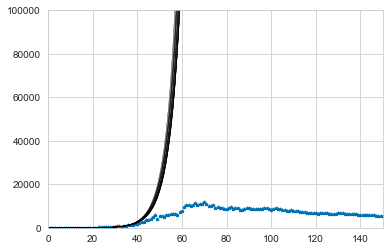

In [478]:
plot_new_cases_sample_exponents(sigma, 20, xlim=(0, 150), ylim=(0, 100000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения

In [479]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [480]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] - sigma), np.exp(mu[1]*days_arr + mu[0] + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

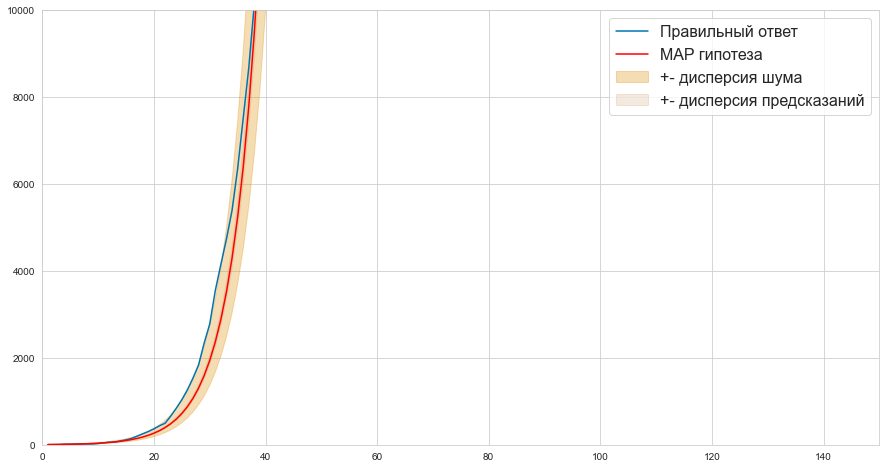

In [481]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred)

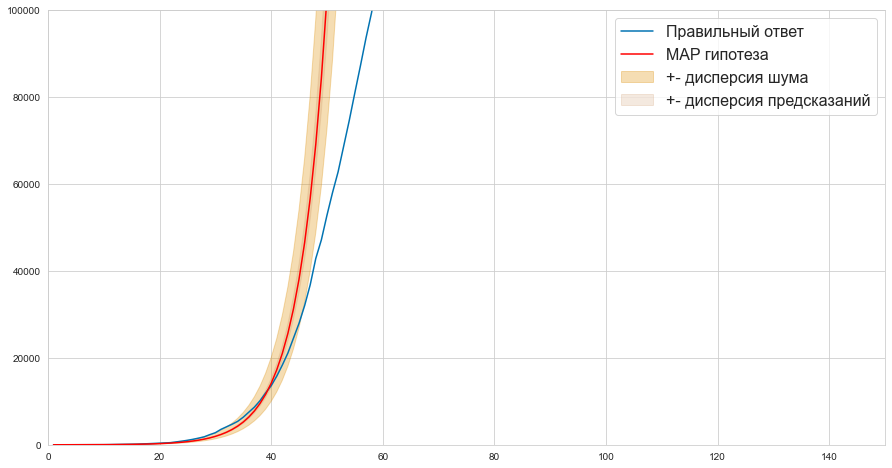

In [482]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 150), ylim=(0, 100000))

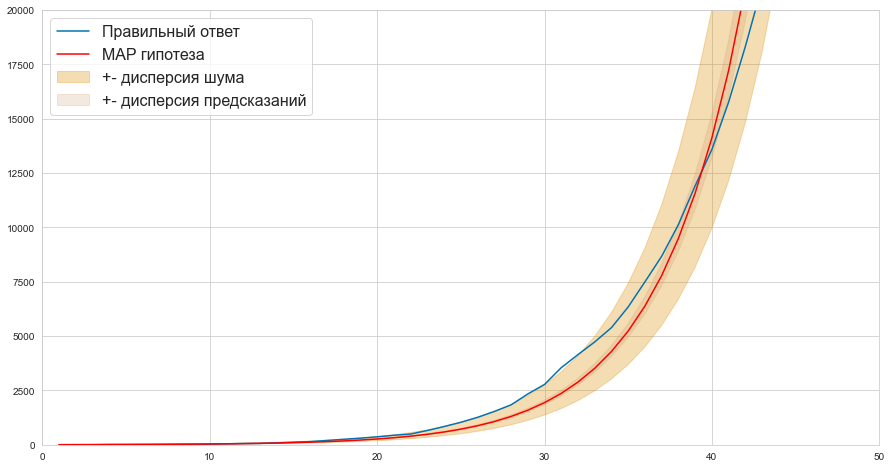

In [483]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 50), ylim=(0, 20000))

## Задание 3

### 3.a

Возьмем производную от Ф(x) ("физический смысл" - скорость прироста случаев) и в качестве целевой переменной возьмём new_cases. Тогда $ln(y) \propto w_0 + w_1 x + w_2 x^2$

Логарифмируем целевую переменную:

In [491]:
train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))

<ipython-input-491-b1987e1897a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))


In [492]:
train_data_new = pd.DataFrame()
train_data_new['days'] = train_data_russia['days']
train_data_new['days_2'] = train_data_new['days']**2

Обучаем модель:

In [493]:
probit_model = LinearRegression()
probit_model.fit(train_data_new, train_data_russia['new_cases'])

LinearRegression()

In [494]:
probit_model.coef_

array([ 0.27928241, -0.00182979])

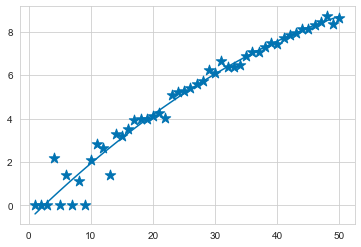

In [499]:
def predicted_curve(x):
    return probit_model.intercept_ + x * probit_model.coef_[0] + x**2 * probit_model.coef_[1]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(train_data_russia['days'].to_numpy(), predicted_curve(train_data_russia['days'].to_numpy()))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 3.b

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [534]:
def get_disp(X, Y, w0, w1, w2):
    return np.sum((Y - w0 - X * w1 - X**2 * w2)**2) / len(X)

In [535]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), exp_model.intercept_, probit_model.coef_[0], probit_model.coef_[1])

In [536]:
sigma = math.sqrt(disp)

In [537]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [538]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[5, 0, 0], [0, 5, 0], [0, 0, 5]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [539]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), sigma)

### 3.c

In [540]:
def plot_sample_sigmoids(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    cases_num = [[], [], []]
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
        cases_num[0].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[60])
        cases_num[1].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[91])
        cases_num[2].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[183])
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)
    return cases_num

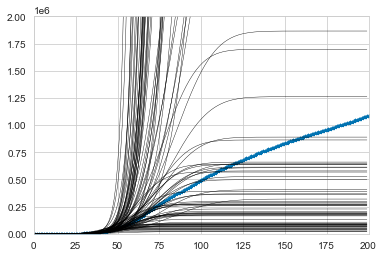

In [541]:
cases_num = plot_sample_sigmoids(sigma, 100, xlim=(0, 200), ylim=(0, 2000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

In [542]:
for i in range(3):
    print(np.percentile(cases_num[i], 10), np.percentile(cases_num[i], 90))

55176.741651636825 1053163.452496401
70206.18806312757 1635741682.5066628
70210.34707127037 2.0406316223489045e+22


Из полученных результатов можно сделать вывод, что в оптимистичном сценарии в России будет порядка 70000 случаев, в пессимистичном сценарии переболеют все.

In [543]:
def plot_new_cases(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs + w[2]*xs**2), 'k-', lw=.4)
    plt.ylim(ylim)
    plt.xlim(xlim)
    if days is not None:
        plt.scatter(days, cases, marker='*', s=10)

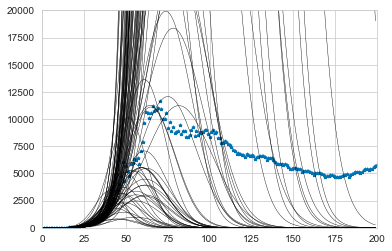

In [544]:
plot_new_cases(sigma, 100, xlim=(0, 200), ylim=(0, 20000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения:

In [545]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs**2
    return res

In [546]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2)), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma)), np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma)), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.cumsum(np.mean(np.exp(predictions), axis=0)) - np.cumsum(np.std(np.exp(predictions), axis=0)), np.cumsum(np.mean(np.exp(predictions), axis=0)) + np.cumsum(np.std(np.exp(predictions), axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


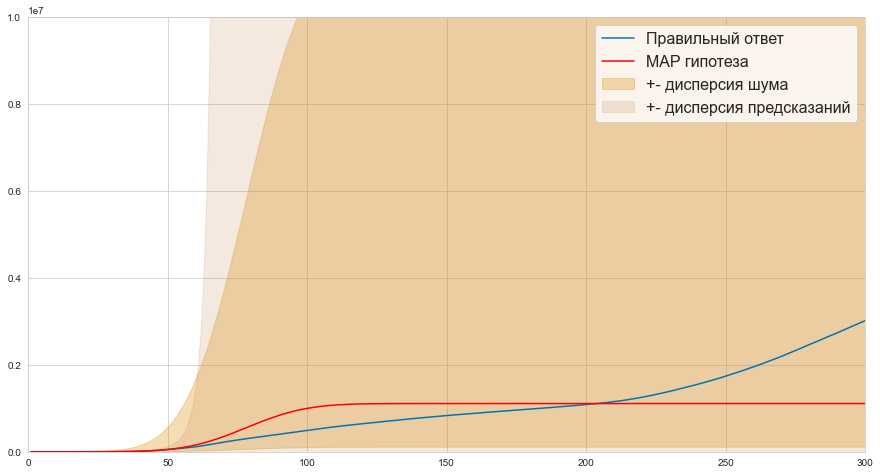

In [548]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 10000000))

In [549]:
def plot_new_cases_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma), np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Alexander\anaconda38\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


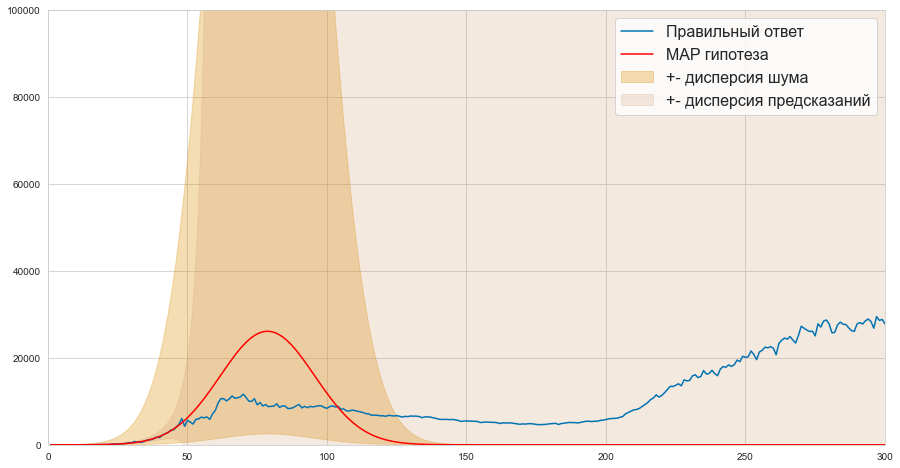

In [551]:
plot_new_cases_predictions(data_russia['days'].to_numpy(), data_russia['new_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 100000))